[link text](https://)  
#  series 4 : Language Model Performance assessment (without attention model)

## Setup

In [1]:
!pip install "tensorflow-text>=2.10"
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 48.7 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully u

In [2]:
import numpy as np
import typing
from typing import Any, Tuple
from sklearn.model_selection import train_test_split

import pathlib

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [3]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

#### Loading the Dataset

In [4]:
import pandas as pd
ORM_data = pd.read_csv('dummy_data2.csv')


In [5]:
ORM_data.head()

,OM_Regular,OM_Prediction
0,"class1,table1,obj1,atr1","class1,table1,obj1,atr1,P"
1,"class1,table2,obj1,atr1","class1,table2,obj1,atr1,P"
2,"class1,table3,obj1,atr1","class1,table3,obj1,atr1,P"
3,"class1,table4,obj1,atr1","class1,table4,obj1,atr1,P"
4,"class1,table5,obj1,atr1","class1,table5,obj1,atr1,P"


In [6]:
OM_Regular = ORM_data['OM_Regular'].values
OM_Prediction = ORM_data['OM_Prediction'].values

In [7]:
X = OM_Regular
Y = OM_Prediction

#### Dividing data as Target and Context

In [8]:
target_raw =  Y
context_raw = X
print(context_raw[-1])

class34,table25,obj23,atr15


In [9]:
print(target_raw[-1])

class34,table25,obj23,atr15,P


### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [10]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 1

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [11]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor([b'class5,table1,obj1,atr1'], shape=(1,), dtype=string)

tf.Tensor([b'class5,table1,obj1,atr1,NP'], shape=(1,), dtype=string)


### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. Mainly using a `layers.TextVectorization` layer.

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation, We may or may not decide to Use this for ORM data. I kept it in the experiment

In [12]:
#example_text = tf.constant('moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38,​OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc1:assoc_type1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`assoc1`(`c5_at1`c5_at1_type`c1_at1`c1_at1_typeKEY`FK_assoc1_c5_at1_idx`(`c5_at1`)KEY`FK_assoc1_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c5_at1``c1_at1`));----CREATETABLE`assoc3``c5_at1`c5_at1_type`c4_at1`c4_at1_typeKEY`FK_assoc3_c5_at1_idx`(`c5_at1`)KEY`FK_assoc3_c4_at1_idx`(`c4_at1`)PRIMARYKEY(`c5_at1``c4_at1`));----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type`c5_at1`c5_at1_typePRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type`c3_at1`c3_at1_typeNOTNULLPRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type`c2_at1`c2_at1_typePRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_typePRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_typePRIMARYKEY(`c1_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type`c6_at3`c6_at3_type`c6_at2`c6_at2_type`c6_at1`c6_at1_typeNOTNULLPRIMARYKEY(`c6_at1`));----CREATETABLE`assoc2`(`c5_at1`c5_at1_type`c2_at1`c2_at1_typeKEY`FK_assoc2_c5_at1_idx`(`c5_at1`)KEY`FK_assoc2_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c5_at1``c2_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL`c2_at1`c2_at1_typeKEY`FK_assoc5_c3_at1_idx`(`c3_at1`)KEY`FK_assoc5_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c3_at1``c2_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL`c2_at1`c2_at1_typeKEY`FK_assoc4_c6_at1_idx`(`c6_at1`)KEY`FK_assoc4_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c6_at1``c2_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc1_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE')

example_text = tf.constant('class1,table2,obj1,atr1')
print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'class1,table2,obj1,atr1'
b'class1,table2,obj1,atr1'


In [13]:
#import re

#def tf_lower_and_split_punct(text):
  # Split accented characters.
  #text = tf_text.normalize_utf8(text, 'NFKD')
  #text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  #pattern = '\s+'
  #re.split(pattern, text, maxsplit=2)
  #text = tf.strings.regex_replace(text, '\s+', '')
  #tf.strings.split(text, sep=', ', maxsplit=2, name=None)
  #tf.strings.split (text, sep='\s+', maxsplit=2, name=None)
  #text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  #tf.strings.split(text, ',')
  #text = tf.strings.split(text, sep=None, maxsplit=-1, name=None)
  #text.tf.strings.split(', ')

  # Add spaces around punctuation.
  #text = tf.strings.regex_replace(text, '', r'')
  # Strip whitespace.
  #text = tf.strings.strip(text)

  #text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  #return text


def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '', r'\0')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [14]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

class1,table2,obj1,atr1
[START] class1,table2,obj1,atr1 [END]


#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [15]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

The `TextVectorization` layer and many other [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fit`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:

In [16]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:50]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['',
 '[UNK]',
 '[START]',
 '[END]',
 'class6,table9,obj1,atr1',
 'class6,table6,obj1,atr1',
 'class6,table5,obj1,atr1',
 'class6,table4,obj1,atr1',
 'class6,table2,obj1,atr1',
 'class6,table18,obj1,atr1',
 'class6,table17,obj1,atr1',
 'class6,table15,obj1,atr1',
 'class6,table14,obj1,atr1',
 'class6,table13,obj1,atr1',
 'class6,table12,obj1,atr1',
 'class6,table11,obj1,atr1',
 'class6,table10,obj1,atr1',
 'class6,table1,obj1,atr1',
 'class5,table9,obj1,atr1',
 'class5,table6,obj1,atr1',
 'class5,table5,obj1,atr1',
 'class5,table4,obj1,atr1',
 'class5,table2,obj1,atr1',
 'class5,table17,obj1,atr1',
 'class5,table16,obj1,atr1',
 'class5,table15,obj1,atr1',
 'class5,table13,obj1,atr1',
 'class5,table11,obj1,atr1',
 'class5,table10,obj1,atr1',
 'class5,table1,obj1,atr1',
 'class4,table9,obj2,atr2',
 'class4,table8,obj2,atr2',
 'class4,table7,obj2,atr2',
 'class4,table6,obj2,atr2',
 'class4,table5,obj2,atr2',
 'class4,table4,obj2,atr2',
 'class4,table3,obj2,atr2',
 'class4,table2,obj2,atr2

That's the context data  `TextVectorization` layer, now build and `.adapt()` for the Target Data one:

In [17]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:50]

['',
 '[UNK]',
 '[START]',
 '[END]',
 'class6,table9,obj1,atr1,np',
 'class6,table6,obj1,atr1,np',
 'class6,table5,obj1,atr1,np',
 'class6,table4,obj1,atr1,np',
 'class6,table2,obj1,atr1,np',
 'class6,table18,obj1,atr1,np',
 'class6,table17,obj1,atr1,np',
 'class6,table15,obj1,atr1,np',
 'class6,table14,obj1,atr1,np',
 'class6,table13,obj1,atr1,np',
 'class6,table12,obj1,atr1,np',
 'class6,table11,obj1,atr1,np',
 'class6,table10,obj1,atr1,np',
 'class6,table1,obj1,atr1,np',
 'class5,table9,obj1,atr1,np',
 'class5,table6,obj1,atr1,np',
 'class5,table5,obj1,atr1,np',
 'class5,table4,obj1,atr1,np',
 'class5,table2,obj1,atr1,np',
 'class5,table17,obj1,atr1,p',
 'class5,table16,obj1,atr1,p',
 'class5,table15,obj1,atr1,p',
 'class5,table13,obj1,atr1,p',
 'class5,table11,obj1,atr1,p',
 'class5,table10,obj1,atr1,p',
 'class5,table1,obj1,atr1,np',
 'class4,table9,obj2,atr2,np',
 'class4,table8,obj2,atr2,np',
 'class4,table7,obj2,atr2,np',
 'class4,table6,obj2,atr2,np',
 'class4,table5,obj2,atr2

Now these layers can convert a batch of strings into a batch of token IDs:

In [18]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 29, 3]]>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [19]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] class5,table1,obj1,atr1 [END]'

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

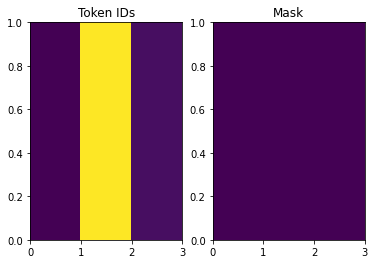

In [20]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### Process the dataset



The `process_text` function below converts the `Datasets` of strings, into  0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with `keras.Model.fit`. Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the labels are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [21]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

Here is the first sequence of each, from the first batch:

In [22]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[ 2 67  3]

[ 2 67]
[67  3]


## The encoder/decoder

  <th colspan=1>This tutorial's model</th>
<tr>
</table>


Before getting into it define constants for the model:

In [23]:
UNITS = 256

### The encoder


The encoder:

1. Takes a list of token IDs (from `context_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a bidirectional `layers.GRU`).
5. Returns the processed sequence. This will be passed to the attention head.

In [24]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [25]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (1, 3)
Encoder output, shape (batch, s, units): (1, 3, 256)


### The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output. 


In [26]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
       query=x,
       value=context,
      return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
  #Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [27]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                 output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (1, 3, 256)
Target sequence, shape (batch, t, units): (1, 2, 256)
Attention result, shape (batch, t, units): (1, 2, 256)
Attention weights, shape (batch, t, s):    (1, 2, 3)


The attention weights will sum to `1` over the context sequence, at each location in the target sequence.

In [28]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1., 1.], dtype=float32)



Here are the attention weights across the context sequences at `t=0`:

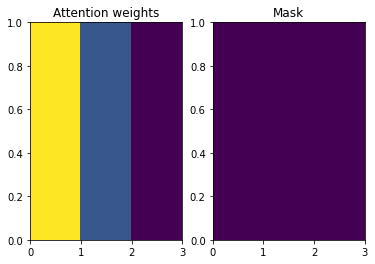

In [29]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


Because of the small-random initialization the attention weights are initially all close to `1/(sequence_length)`. The model will learn to make these less uniform as training progresses.

### The decoder

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.


Here is the `Decoder` class' initializer. The initializer creates all the necessary layers.

In [30]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

Next, the `call` method, takes 3 arguments:

* `inputs` -  a `context, x` pair where:
  * `context` - is the context from the encoder's output.
  * `x` - is the target sequence input.
* `state` - Optional, the previous `state` output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where you left off.
* `return_state` - [Default: False] - Set this to `True` to return the RNN state. 

In [31]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [32]:
decoder = Decoder(target_text_processor, UNITS)

Decoder usage

In [33]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (1, 3, 256)
input target tokens shape: (batch, t) (1, 2)
logits shape shape: (batch, target_vocabulary_size) (1, 2, 100)


#### Inference

For inference usage couple more methods.

In [34]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [35]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [36]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

With those extra functions, you can write a generation loop:

In [37]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'class5,table16,obj1,atr1,p class4,table18,obj2,atr2,np class2,table4,obj2,atr2,np class34,table11,obj23,atr1,p class4,table1,obj2,atr2,np class6,table2,obj1,atr1,np class4,table16,obj2,atr2,np class6,table4,obj1,atr1,np class5,table1,obj1,atr1,np class3,table2,obj1,atr1,p'],
      dtype=object)



```
# This is formatted as code
```

**Since the model's untrained, it outputs items from the vocabulary almost uniformly at random. **

## The model


In [38]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

During training the model will be used like this:

In [39]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (1, 3)
Target tokens, shape: (batch, t) (1, 2)
logits, shape: (batch, t, target_vocabulary_size) (1, 2, 100)


### Train

In [40]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [41]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [42]:
model.compile(optimizer='Adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [43]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 4.6051702, 'expected_acc': 0.01}

That should roughly match the values returned by running a few steps of evaluation:

In [44]:
model.evaluate(val_ds, steps=40, return_dict=True)

18/40 [============>.................] - ETA: 0s - loss: 4.6292 - masked_acc: 0.0000e+00 - masked_loss: 4.6292

40/40 [==============================] - 13s 15ms/step - loss: 4.6292 - masked_acc: 0.0000e+00 - masked_loss: 4.6292


{'loss': 4.629204273223877,
 'masked_acc': 0.0,
 'masked_loss': 4.629204273223877}

In [45]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 40,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 3.1343 - masked_acc: 0.4949 - masked_loss: 3.1343

100/100 [==============================] - 23s 35ms/step - loss: 3.1230 - masked_acc: 0.4950 - masked_loss: 3.1230 - val_loss: 2.7887 - val_masked_acc: 0.5000 - val_masked_loss: 2.7887
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 3.1624 - masked_acc: 0.5051 - masked_loss: 3.1624

100/100 [==============================] - 3s 32ms/step - loss: 3.1574 - masked_acc: 0.5050 - masked_loss: 3.1574
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 2.5166 - masked_acc: 0.5051 - masked_loss: 2.5166

100/100 [==============================] - 3s 33ms/step - loss: 2.5125 - masked_acc: 0.5050 - masked_loss: 2.5125
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 2.3099 - masked_acc: 0.5101 - masked_loss: 2.3099

100/100 [==============================] - 3s 33ms/step - loss: 2.2925 - masked_acc: 0.5150 - masked_loss: 2.2925
Epoch 5/100
100/100 [==============================] - ETA: 0s - loss: 1.8382 - masked_acc: 0.5300 - masked_loss: 1.8382

100/100 [==============================] - 3s 32ms/step - loss: 1.8382 - masked_acc: 0.5300 - masked_loss: 1.8382
Epoch 6/100
100/100 [==============================] - ETA: 0s - loss: 1.3500 - masked_acc: 0.6250 - masked_loss: 1.3500

100/100 [==============================] - 3s 34ms/step - loss: 1.3500 - masked_acc: 0.6250 - masked_loss: 1.3500
Epoch 7/100
 99/100 [============================>.] - ETA: 0s - loss: 0.7139 - masked_acc: 0.7980 - masked_loss: 0.7139

100/100 [==============================] - 3s 32ms/step - loss: 0.7103 - masked_acc: 0.8000 - masked_loss: 0.7103
Epoch 8/100
 99/100 [============================>.] - ETA: 0s - loss: 0.2221 - masked_acc: 0.9697 - masked_loss: 0.2221

100/100 [==============================] - 3s 32ms/step - loss: 0.2224 - masked_acc: 0.9700 - masked_loss: 0.2224
Epoch 9/100
100/100 [==============================] - ETA: 0s - loss: 0.0446 - masked_acc: 1.0000 - masked_loss: 0.0446

100/100 [==============================] - 3s 33ms/step - loss: 0.0446 - masked_acc: 1.0000 - masked_loss: 0.0446
Epoch 10/100
100/100 [==============================] - ETA: 0s - loss: 0.0172 - masked_acc: 1.0000 - masked_loss: 0.0172

100/100 [==============================] - 3s 32ms/step - loss: 0.0172 - masked_acc: 1.0000 - masked_loss: 0.0172
Epoch 11/100
100/100 [==============================] - ETA: 0s - loss: 0.0116 - masked_acc: 1.0000 - masked_loss: 0.0116

100/100 [==============================] - 3s 33ms/step - loss: 0.0116 - masked_acc: 1.0000 - masked_loss: 0.0116
Epoch 12/100
100/100 [==============================] - ETA: 0s - loss: 0.0096 - masked_acc: 1.0000 - masked_loss: 0.0096

100/100 [==============================] - 3s 34ms/step - loss: 0.0096 - masked_acc: 1.0000 - masked_loss: 0.0096
Epoch 13/100
100/100 [==============================] - ETA: 0s - loss: 0.0081 - masked_acc: 1.0000 - masked_loss: 0.0081

100/100 [==============================] - 3s 34ms/step - loss: 0.0081 - masked_acc: 1.0000 - masked_loss: 0.0081
Epoch 14/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0073 - masked_acc: 1.0000 - masked_loss: 0.0073

100/100 [==============================] - 3s 32ms/step - loss: 0.0073 - masked_acc: 1.0000 - masked_loss: 0.0073
Epoch 15/100
100/100 [==============================] - ETA: 0s - loss: 0.0065 - masked_acc: 1.0000 - masked_loss: 0.0065

100/100 [==============================] - 3s 33ms/step - loss: 0.0065 - masked_acc: 1.0000 - masked_loss: 0.0065
Epoch 16/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0054 - masked_acc: 1.0000 - masked_loss: 0.0054

100/100 [==============================] - 3s 32ms/step - loss: 0.0054 - masked_acc: 1.0000 - masked_loss: 0.0054
Epoch 17/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0051 - masked_acc: 1.0000 - masked_loss: 0.0051

100/100 [==============================] - 3s 31ms/step - loss: 0.0051 - masked_acc: 1.0000 - masked_loss: 0.0051
Epoch 18/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0045 - masked_acc: 1.0000 - masked_loss: 0.0045

100/100 [==============================] - 3s 32ms/step - loss: 0.0045 - masked_acc: 1.0000 - masked_loss: 0.0045
Epoch 19/100
100/100 [==============================] - ETA: 0s - loss: 0.0042 - masked_acc: 1.0000 - masked_loss: 0.0042

100/100 [==============================] - 3s 32ms/step - loss: 0.0042 - masked_acc: 1.0000 - masked_loss: 0.0042
Epoch 20/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0038 - masked_acc: 1.0000 - masked_loss: 0.0038

100/100 [==============================] - 3s 31ms/step - loss: 0.0038 - masked_acc: 1.0000 - masked_loss: 0.0038
Epoch 21/100
100/100 [==============================] - ETA: 0s - loss: 0.0034 - masked_acc: 1.0000 - masked_loss: 0.0034

100/100 [==============================] - 3s 32ms/step - loss: 0.0034 - masked_acc: 1.0000 - masked_loss: 0.0034
Epoch 22/100
100/100 [==============================] - ETA: 0s - loss: 0.0032 - masked_acc: 1.0000 - masked_loss: 0.0032

100/100 [==============================] - 3s 32ms/step - loss: 0.0032 - masked_acc: 1.0000 - masked_loss: 0.0032
Epoch 23/100
100/100 [==============================] - ETA: 0s - loss: 0.0029 - masked_acc: 1.0000 - masked_loss: 0.0029

100/100 [==============================] - 4s 42ms/step - loss: 0.0029 - masked_acc: 1.0000 - masked_loss: 0.0029
Epoch 24/100
100/100 [==============================] - ETA: 0s - loss: 0.0027 - masked_acc: 1.0000 - masked_loss: 0.0027

100/100 [==============================] - 3s 33ms/step - loss: 0.0027 - masked_acc: 1.0000 - masked_loss: 0.0027
Epoch 25/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0025 - masked_acc: 1.0000 - masked_loss: 0.0025

100/100 [==============================] - 3s 34ms/step - loss: 0.0025 - masked_acc: 1.0000 - masked_loss: 0.0025
Epoch 26/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0023 - masked_acc: 1.0000 - masked_loss: 0.0023

100/100 [==============================] - 3s 33ms/step - loss: 0.0023 - masked_acc: 1.0000 - masked_loss: 0.0023
Epoch 27/100
100/100 [==============================] - ETA: 0s - loss: 0.0021 - masked_acc: 1.0000 - masked_loss: 0.0021

100/100 [==============================] - 3s 33ms/step - loss: 0.0021 - masked_acc: 1.0000 - masked_loss: 0.0021
Epoch 28/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0020 - masked_acc: 1.0000 - masked_loss: 0.0020

100/100 [==============================] - 3s 32ms/step - loss: 0.0020 - masked_acc: 1.0000 - masked_loss: 0.0020
Epoch 29/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0018 - masked_acc: 1.0000 - masked_loss: 0.0018

100/100 [==============================] - 3s 33ms/step - loss: 0.0018 - masked_acc: 1.0000 - masked_loss: 0.0018
Epoch 30/100
100/100 [==============================] - ETA: 0s - loss: 0.0017 - masked_acc: 1.0000 - masked_loss: 0.0017

100/100 [==============================] - 3s 33ms/step - loss: 0.0017 - masked_acc: 1.0000 - masked_loss: 0.0017
Epoch 31/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0016 - masked_acc: 1.0000 - masked_loss: 0.0016

100/100 [==============================] - 3s 32ms/step - loss: 0.0016 - masked_acc: 1.0000 - masked_loss: 0.0016
Epoch 32/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0015 - masked_acc: 1.0000 - masked_loss: 0.0015

100/100 [==============================] - 3s 32ms/step - loss: 0.0015 - masked_acc: 1.0000 - masked_loss: 0.0015
Epoch 33/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0014 - masked_acc: 1.0000 - masked_loss: 0.0014

100/100 [==============================] - 3s 34ms/step - loss: 0.0014 - masked_acc: 1.0000 - masked_loss: 0.0014
Epoch 34/100
100/100 [==============================] - ETA: 0s - loss: 0.0013 - masked_acc: 1.0000 - masked_loss: 0.0013

100/100 [==============================] - 3s 34ms/step - loss: 0.0013 - masked_acc: 1.0000 - masked_loss: 0.0013
Epoch 35/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0012 - masked_acc: 1.0000 - masked_loss: 0.0012

100/100 [==============================] - 3s 33ms/step - loss: 0.0012 - masked_acc: 1.0000 - masked_loss: 0.0012
Epoch 36/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0012 - masked_acc: 1.0000 - masked_loss: 0.0012

100/100 [==============================] - 3s 34ms/step - loss: 0.0012 - masked_acc: 1.0000 - masked_loss: 0.0012
Epoch 37/100
100/100 [==============================] - ETA: 0s - loss: 0.0011 - masked_acc: 1.0000 - masked_loss: 0.0011

100/100 [==============================] - 4s 36ms/step - loss: 0.0011 - masked_acc: 1.0000 - masked_loss: 0.0011
Epoch 38/100
100/100 [==============================] - ETA: 0s - loss: 9.9873e-04 - masked_acc: 1.0000 - masked_loss: 9.9873e-04

100/100 [==============================] - 5s 48ms/step - loss: 9.9873e-04 - masked_acc: 1.0000 - masked_loss: 9.9873e-04
Epoch 39/100
 99/100 [============================>.] - ETA: 0s - loss: 9.6543e-04 - masked_acc: 1.0000 - masked_loss: 9.6543e-04

100/100 [==============================] - 4s 35ms/step - loss: 9.6501e-04 - masked_acc: 1.0000 - masked_loss: 9.6501e-04
Epoch 40/100
100/100 [==============================] - ETA: 0s - loss: 8.8181e-04 - masked_acc: 1.0000 - masked_loss: 8.8181e-04

100/100 [==============================] - 3s 32ms/step - loss: 8.8181e-04 - masked_acc: 1.0000 - masked_loss: 8.8181e-04
Epoch 41/100
 99/100 [============================>.] - ETA: 0s - loss: 8.5521e-04 - masked_acc: 1.0000 - masked_loss: 8.5521e-04

100/100 [==============================] - 3s 32ms/step - loss: 8.5401e-04 - masked_acc: 1.0000 - masked_loss: 8.5401e-04
Epoch 42/100
 99/100 [============================>.] - ETA: 0s - loss: 7.8084e-04 - masked_acc: 1.0000 - masked_loss: 7.8084e-04

100/100 [==============================] - 3s 32ms/step - loss: 7.8135e-04 - masked_acc: 1.0000 - masked_loss: 7.8135e-04
Epoch 43/100
 99/100 [============================>.] - ETA: 0s - loss: 7.5541e-04 - masked_acc: 1.0000 - masked_loss: 7.5541e-04

100/100 [==============================] - 3s 32ms/step - loss: 7.5771e-04 - masked_acc: 1.0000 - masked_loss: 7.5771e-04
Epoch 44/100
100/100 [==============================] - ETA: 0s - loss: 7.1313e-04 - masked_acc: 1.0000 - masked_loss: 7.1313e-04

100/100 [==============================] - 3s 32ms/step - loss: 7.1313e-04 - masked_acc: 1.0000 - masked_loss: 7.1313e-04
Epoch 45/100
 99/100 [============================>.] - ETA: 0s - loss: 6.6617e-04 - masked_acc: 1.0000 - masked_loss: 6.6617e-04

100/100 [==============================] - 3s 32ms/step - loss: 6.6702e-04 - masked_acc: 1.0000 - masked_loss: 6.6702e-04
Epoch 46/100
 99/100 [============================>.] - ETA: 0s - loss: 6.1927e-04 - masked_acc: 1.0000 - masked_loss: 6.1927e-04

100/100 [==============================] - 3s 31ms/step - loss: 6.1959e-04 - masked_acc: 1.0000 - masked_loss: 6.1959e-04
Epoch 47/100
 99/100 [============================>.] - ETA: 0s - loss: 5.9523e-04 - masked_acc: 1.0000 - masked_loss: 5.9523e-04

100/100 [==============================] - 3s 31ms/step - loss: 5.9545e-04 - masked_acc: 1.0000 - masked_loss: 5.9545e-04
Epoch 48/100
100/100 [==============================] - ETA: 0s - loss: 5.5855e-04 - masked_acc: 1.0000 - masked_loss: 5.5855e-04

100/100 [==============================] - 3s 31ms/step - loss: 5.5855e-04 - masked_acc: 1.0000 - masked_loss: 5.5855e-04
Epoch 49/100
100/100 [==============================] - ETA: 0s - loss: 5.2748e-04 - masked_acc: 1.0000 - masked_loss: 5.2748e-04

100/100 [==============================] - 3s 32ms/step - loss: 5.2748e-04 - masked_acc: 1.0000 - masked_loss: 5.2748e-04
Epoch 50/100
 99/100 [============================>.] - ETA: 0s - loss: 4.9634e-04 - masked_acc: 1.0000 - masked_loss: 4.9634e-04

100/100 [==============================] - 3s 33ms/step - loss: 4.9630e-04 - masked_acc: 1.0000 - masked_loss: 4.9630e-04
Epoch 51/100
 99/100 [============================>.] - ETA: 0s - loss: 4.7023e-04 - masked_acc: 1.0000 - masked_loss: 4.7023e-04

100/100 [==============================] - 3s 32ms/step - loss: 4.7018e-04 - masked_acc: 1.0000 - masked_loss: 4.7018e-04
Epoch 52/100
 99/100 [============================>.] - ETA: 0s - loss: 4.4562e-04 - masked_acc: 1.0000 - masked_loss: 4.4562e-04

100/100 [==============================] - 3s 33ms/step - loss: 4.4569e-04 - masked_acc: 1.0000 - masked_loss: 4.4569e-04
Epoch 53/100
 99/100 [============================>.] - ETA: 0s - loss: 4.2048e-04 - masked_acc: 1.0000 - masked_loss: 4.2048e-04

100/100 [==============================] - 3s 33ms/step - loss: 4.2091e-04 - masked_acc: 1.0000 - masked_loss: 4.2091e-04
Epoch 54/100
 99/100 [============================>.] - ETA: 0s - loss: 3.9649e-04 - masked_acc: 1.0000 - masked_loss: 3.9649e-04

100/100 [==============================] - 3s 33ms/step - loss: 3.9731e-04 - masked_acc: 1.0000 - masked_loss: 3.9731e-04
Epoch 55/100
 99/100 [============================>.] - ETA: 0s - loss: 3.7798e-04 - masked_acc: 1.0000 - masked_loss: 3.7798e-04

100/100 [==============================] - 3s 34ms/step - loss: 3.7795e-04 - masked_acc: 1.0000 - masked_loss: 3.7795e-04
Epoch 56/100
 99/100 [============================>.] - ETA: 0s - loss: 3.5742e-04 - masked_acc: 1.0000 - masked_loss: 3.5742e-04

100/100 [==============================] - 3s 32ms/step - loss: 3.5715e-04 - masked_acc: 1.0000 - masked_loss: 3.5715e-04
Epoch 57/100
 99/100 [============================>.] - ETA: 0s - loss: 3.3093e-04 - masked_acc: 1.0000 - masked_loss: 3.3093e-04

100/100 [==============================] - 3s 34ms/step - loss: 3.3098e-04 - masked_acc: 1.0000 - masked_loss: 3.3098e-04
Epoch 58/100
 99/100 [============================>.] - ETA: 0s - loss: 3.1929e-04 - masked_acc: 1.0000 - masked_loss: 3.1929e-04

100/100 [==============================] - 3s 34ms/step - loss: 3.1899e-04 - masked_acc: 1.0000 - masked_loss: 3.1899e-04
Epoch 59/100
 99/100 [============================>.] - ETA: 0s - loss: 3.0018e-04 - masked_acc: 1.0000 - masked_loss: 3.0018e-04

100/100 [==============================] - 3s 33ms/step - loss: 3.0011e-04 - masked_acc: 1.0000 - masked_loss: 3.0011e-04
Epoch 60/100
 99/100 [============================>.] - ETA: 0s - loss: 2.9136e-04 - masked_acc: 1.0000 - masked_loss: 2.9136e-04

100/100 [==============================] - 3s 33ms/step - loss: 2.9146e-04 - masked_acc: 1.0000 - masked_loss: 2.9146e-04
Epoch 61/100
 99/100 [============================>.] - ETA: 0s - loss: 2.7113e-04 - masked_acc: 1.0000 - masked_loss: 2.7113e-04

100/100 [==============================] - 3s 33ms/step - loss: 2.7071e-04 - masked_acc: 1.0000 - masked_loss: 2.7071e-04
Epoch 62/100
100/100 [==============================] - ETA: 0s - loss: 2.5494e-04 - masked_acc: 1.0000 - masked_loss: 2.5494e-04

100/100 [==============================] - 3s 32ms/step - loss: 2.5494e-04 - masked_acc: 1.0000 - masked_loss: 2.5494e-04
Epoch 63/100
 99/100 [============================>.] - ETA: 0s - loss: 2.4488e-04 - masked_acc: 1.0000 - masked_loss: 2.4488e-04

100/100 [==============================] - 3s 31ms/step - loss: 2.4503e-04 - masked_acc: 1.0000 - masked_loss: 2.4503e-04
Epoch 64/100
100/100 [==============================] - ETA: 0s - loss: 2.3078e-04 - masked_acc: 1.0000 - masked_loss: 2.3078e-04

100/100 [==============================] - 3s 32ms/step - loss: 2.3078e-04 - masked_acc: 1.0000 - masked_loss: 2.3078e-04
Epoch 65/100
 99/100 [============================>.] - ETA: 0s - loss: 2.1797e-04 - masked_acc: 1.0000 - masked_loss: 2.1797e-04

100/100 [==============================] - 3s 32ms/step - loss: 2.1756e-04 - masked_acc: 1.0000 - masked_loss: 2.1756e-04
Epoch 66/100
100/100 [==============================] - ETA: 0s - loss: 2.0624e-04 - masked_acc: 1.0000 - masked_loss: 2.0624e-04

100/100 [==============================] - 3s 32ms/step - loss: 2.0624e-04 - masked_acc: 1.0000 - masked_loss: 2.0624e-04
Epoch 67/100
100/100 [==============================] - ETA: 0s - loss: 1.9925e-04 - masked_acc: 1.0000 - masked_loss: 1.9925e-04

100/100 [==============================] - 3s 32ms/step - loss: 1.9925e-04 - masked_acc: 1.0000 - masked_loss: 1.9925e-04
Epoch 68/100
 99/100 [============================>.] - ETA: 0s - loss: 1.8440e-04 - masked_acc: 1.0000 - masked_loss: 1.8440e-04

100/100 [==============================] - 3s 32ms/step - loss: 1.8403e-04 - masked_acc: 1.0000 - masked_loss: 1.8403e-04
Epoch 69/100
 99/100 [============================>.] - ETA: 0s - loss: 1.7628e-04 - masked_acc: 1.0000 - masked_loss: 1.7628e-04

100/100 [==============================] - 3s 32ms/step - loss: 1.7639e-04 - masked_acc: 1.0000 - masked_loss: 1.7639e-04
Epoch 70/100
 99/100 [============================>.] - ETA: 0s - loss: 1.6751e-04 - masked_acc: 1.0000 - masked_loss: 1.6751e-04

100/100 [==============================] - 3s 33ms/step - loss: 1.6760e-04 - masked_acc: 1.0000 - masked_loss: 1.6760e-04
Epoch 71/100
 99/100 [============================>.] - ETA: 0s - loss: 1.5915e-04 - masked_acc: 1.0000 - masked_loss: 1.5915e-04

100/100 [==============================] - 3s 32ms/step - loss: 1.5923e-04 - masked_acc: 1.0000 - masked_loss: 1.5923e-04
Epoch 72/100
100/100 [==============================] - ETA: 0s - loss: 1.5043e-04 - masked_acc: 1.0000 - masked_loss: 1.5043e-04

100/100 [==============================] - 3s 33ms/step - loss: 1.5043e-04 - masked_acc: 1.0000 - masked_loss: 1.5043e-04
Epoch 73/100
 99/100 [============================>.] - ETA: 0s - loss: 1.4192e-04 - masked_acc: 1.0000 - masked_loss: 1.4192e-04

100/100 [==============================] - 3s 33ms/step - loss: 1.4183e-04 - masked_acc: 1.0000 - masked_loss: 1.4183e-04
Epoch 74/100
100/100 [==============================] - ETA: 0s - loss: 1.3535e-04 - masked_acc: 1.0000 - masked_loss: 1.3535e-04

100/100 [==============================] - 3s 32ms/step - loss: 1.3535e-04 - masked_acc: 1.0000 - masked_loss: 1.3535e-04
Epoch 75/100
100/100 [==============================] - ETA: 0s - loss: 1.2784e-04 - masked_acc: 1.0000 - masked_loss: 1.2784e-04

100/100 [==============================] - 3s 32ms/step - loss: 1.2784e-04 - masked_acc: 1.0000 - masked_loss: 1.2784e-04
Epoch 76/100
 99/100 [============================>.] - ETA: 0s - loss: 1.2082e-04 - masked_acc: 1.0000 - masked_loss: 1.2082e-04

100/100 [==============================] - 3s 33ms/step - loss: 1.2060e-04 - masked_acc: 1.0000 - masked_loss: 1.2060e-04
Epoch 77/100
 99/100 [============================>.] - ETA: 0s - loss: 1.1628e-04 - masked_acc: 1.0000 - masked_loss: 1.1628e-04

100/100 [==============================] - 3s 33ms/step - loss: 1.1645e-04 - masked_acc: 1.0000 - masked_loss: 1.1645e-04
Epoch 78/100
100/100 [==============================] - ETA: 0s - loss: 1.0918e-04 - masked_acc: 1.0000 - masked_loss: 1.0918e-04

100/100 [==============================] - 3s 32ms/step - loss: 1.0918e-04 - masked_acc: 1.0000 - masked_loss: 1.0918e-04
Epoch 79/100
 99/100 [============================>.] - ETA: 0s - loss: 1.0398e-04 - masked_acc: 1.0000 - masked_loss: 1.0398e-04

100/100 [==============================] - 3s 32ms/step - loss: 1.0390e-04 - masked_acc: 1.0000 - masked_loss: 1.0390e-04
Epoch 80/100
 99/100 [============================>.] - ETA: 0s - loss: 9.7008e-05 - masked_acc: 1.0000 - masked_loss: 9.7008e-05

100/100 [==============================] - 3s 32ms/step - loss: 9.6953e-05 - masked_acc: 1.0000 - masked_loss: 9.6953e-05
Epoch 81/100
 99/100 [============================>.] - ETA: 0s - loss: 9.3384e-05 - masked_acc: 1.0000 - masked_loss: 9.3384e-05

100/100 [==============================] - 3s 32ms/step - loss: 9.3385e-05 - masked_acc: 1.0000 - masked_loss: 9.3385e-05
Epoch 82/100
100/100 [==============================] - ETA: 0s - loss: 8.8839e-05 - masked_acc: 1.0000 - masked_loss: 8.8839e-05

100/100 [==============================] - 3s 32ms/step - loss: 8.8839e-05 - masked_acc: 1.0000 - masked_loss: 8.8839e-05
Epoch 83/100
100/100 [==============================] - ETA: 0s - loss: 8.3117e-05 - masked_acc: 1.0000 - masked_loss: 8.3117e-05

100/100 [==============================] - 3s 33ms/step - loss: 8.3117e-05 - masked_acc: 1.0000 - masked_loss: 8.3117e-05
Epoch 84/100
100/100 [==============================] - ETA: 0s - loss: 7.9944e-05 - masked_acc: 1.0000 - masked_loss: 7.9944e-05

100/100 [==============================] - 3s 32ms/step - loss: 7.9944e-05 - masked_acc: 1.0000 - masked_loss: 7.9944e-05
Epoch 85/100
 99/100 [============================>.] - ETA: 0s - loss: 7.5552e-05 - masked_acc: 1.0000 - masked_loss: 7.5552e-05

100/100 [==============================] - 3s 33ms/step - loss: 7.5566e-05 - masked_acc: 1.0000 - masked_loss: 7.5566e-05
Epoch 86/100
 99/100 [============================>.] - ETA: 0s - loss: 7.1518e-05 - masked_acc: 1.0000 - masked_loss: 7.1518e-05

100/100 [==============================] - 3s 32ms/step - loss: 7.1491e-05 - masked_acc: 1.0000 - masked_loss: 7.1491e-05
Epoch 87/100
 99/100 [============================>.] - ETA: 0s - loss: 6.7756e-05 - masked_acc: 1.0000 - masked_loss: 6.7756e-05

100/100 [==============================] - 3s 33ms/step - loss: 6.7710e-05 - masked_acc: 1.0000 - masked_loss: 6.7710e-05
Epoch 88/100
 99/100 [============================>.] - ETA: 0s - loss: 6.5102e-05 - masked_acc: 1.0000 - masked_loss: 6.5102e-05

100/100 [==============================] - 3s 32ms/step - loss: 6.5155e-05 - masked_acc: 1.0000 - masked_loss: 6.5155e-05
Epoch 89/100
100/100 [==============================] - ETA: 0s - loss: 6.0570e-05 - masked_acc: 1.0000 - masked_loss: 6.0570e-05

100/100 [==============================] - 3s 32ms/step - loss: 6.0570e-05 - masked_acc: 1.0000 - masked_loss: 6.0570e-05
Epoch 90/100
 99/100 [============================>.] - ETA: 0s - loss: 5.7721e-05 - masked_acc: 1.0000 - masked_loss: 5.7721e-05

100/100 [==============================] - 3s 32ms/step - loss: 5.7648e-05 - masked_acc: 1.0000 - masked_loss: 5.7648e-05
Epoch 91/100
 99/100 [============================>.] - ETA: 0s - loss: 5.5213e-05 - masked_acc: 1.0000 - masked_loss: 5.5213e-05

100/100 [==============================] - 3s 32ms/step - loss: 5.5129e-05 - masked_acc: 1.0000 - masked_loss: 5.5129e-05
Epoch 92/100
100/100 [==============================] - ETA: 0s - loss: 5.2412e-05 - masked_acc: 1.0000 - masked_loss: 5.2412e-05

100/100 [==============================] - 3s 33ms/step - loss: 5.2412e-05 - masked_acc: 1.0000 - masked_loss: 5.2412e-05
Epoch 93/100
 99/100 [============================>.] - ETA: 0s - loss: 4.9503e-05 - masked_acc: 1.0000 - masked_loss: 4.9503e-05

100/100 [==============================] - 3s 32ms/step - loss: 4.9553e-05 - masked_acc: 1.0000 - masked_loss: 4.9553e-05
Epoch 94/100
 99/100 [============================>.] - ETA: 0s - loss: 4.6818e-05 - masked_acc: 1.0000 - masked_loss: 4.6818e-05

100/100 [==============================] - 3s 32ms/step - loss: 4.6872e-05 - masked_acc: 1.0000 - masked_loss: 4.6872e-05
Epoch 95/100
 99/100 [============================>.] - ETA: 0s - loss: 4.4180e-05 - masked_acc: 1.0000 - masked_loss: 4.4180e-05

100/100 [==============================] - 3s 32ms/step - loss: 4.4182e-05 - masked_acc: 1.0000 - masked_loss: 4.4182e-05
Epoch 96/100
 99/100 [============================>.] - ETA: 0s - loss: 4.2168e-05 - masked_acc: 1.0000 - masked_loss: 4.2168e-05

100/100 [==============================] - 3s 32ms/step - loss: 4.2202e-05 - masked_acc: 1.0000 - masked_loss: 4.2202e-05
Epoch 97/100
 99/100 [============================>.] - ETA: 0s - loss: 4.0033e-05 - masked_acc: 1.0000 - masked_loss: 4.0033e-05

100/100 [==============================] - 3s 32ms/step - loss: 4.0017e-05 - masked_acc: 1.0000 - masked_loss: 4.0017e-05
Epoch 98/100
 99/100 [============================>.] - ETA: 0s - loss: 3.7806e-05 - masked_acc: 1.0000 - masked_loss: 3.7806e-05

100/100 [==============================] - 3s 33ms/step - loss: 3.7803e-05 - masked_acc: 1.0000 - masked_loss: 3.7803e-05
Epoch 99/100
100/100 [==============================] - ETA: 0s - loss: 3.5763e-05 - masked_acc: 1.0000 - masked_loss: 3.5763e-05

100/100 [==============================] - 3s 34ms/step - loss: 3.5763e-05 - masked_acc: 1.0000 - masked_loss: 3.5763e-05
Epoch 100/100
 99/100 [============================>.] - ETA: 0s - loss: 3.4235e-05 - masked_acc: 1.0000 - masked_loss: 3.4235e-05

100/100 [==============================] - 3s 32ms/step - loss: 3.4214e-05 - masked_acc: 1.0000 - masked_loss: 3.4214e-05


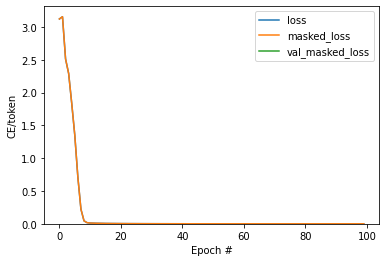

In [46]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['masked_loss'], label='masked_loss')
plt.plot(history.history['val_masked_loss'], label='val_masked_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

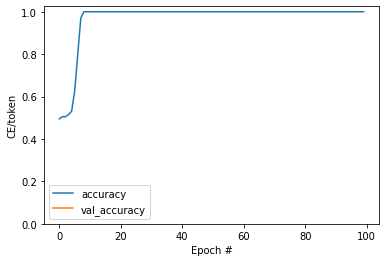

In [47]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Translate

Now that the model is trained, implement a function to execute the full `text => text` translation. This code is basically identical to the [inference example](#inference) in the [decoder section](#the_decoder), but this also captures the attention weights.

In [48]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

Here are the two helper methods, used above, to convert tokens to text, and to get the next token:

In [49]:
#sample Dataset Library_Management_Dataset_1_input_prerp_each_class_and_entitities_sep_experiment 



result1 = model.translate(['class1,table6,obj1,atr1'])

result2 = model.translate(['class4,table17,obj2,atr2'])

result23 = model.translate(['class14,table2,obj1,atr1'])

result222 = model.translate(['class17,table4,obj2,atr2'])
#result1[0].numpy().decode()
result23[0].numpy().decode()



'class5,table10,obj1,atr1,p '

Use that to generate the attention plot:

In [50]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

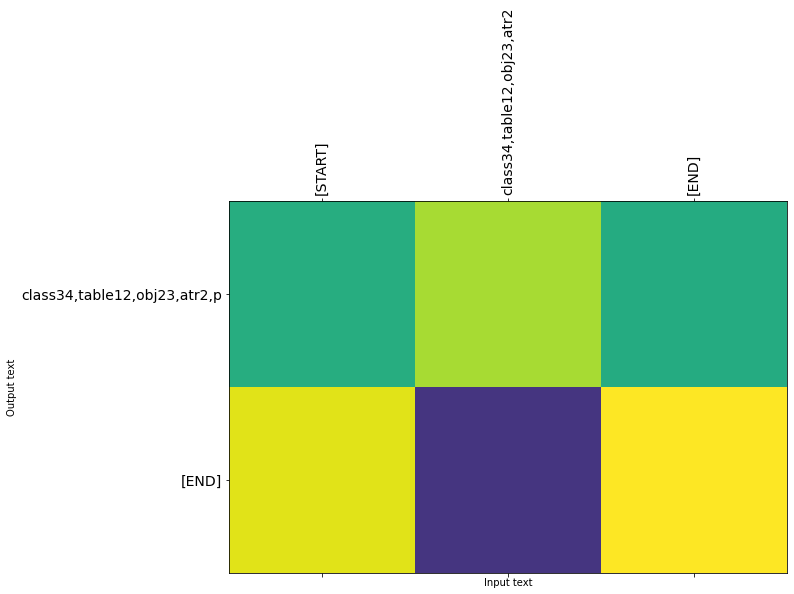

In [53]:
model.plot_attention('class34,table12,obj23,atr2') # Are you still home

Translate a few more sentences and plot them:

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state looses track of where it was in the context sequence there's no way for the model to recover. [Transformers](transformer.ipynb) improve on this by letting the decoder look at what it has output so far.

The raw data is sorted by length, so try translating the longest sequence:

In [54]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 class34,table25,obj23,atr15,P


#Testing existing samples

In [55]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report

In [63]:
df = pd.read_csv('dummy_data_test_set2.csv')

In [64]:
df.head()

,OM_Regular,OM_Prediction
0,"class1,table1,obj1,atr1",1
1,"class1,table2,obj1,atr1",1
2,"class1,table3,obj1,atr1",1
3,"class1,table4,obj1,atr1",1
4,"class1,table5,obj1,atr1",1


In [65]:
X_test = df['OM_Regular'].values
y_test = df['OM_Prediction'].values

In [66]:
print(X_test.shape)
print(y_test.shape)

print("\nX data type: ", X_test.dtype)
print("y data type: ", y_test.dtype)

(122,)
(122,)

X data type:  object
y data type:  int64


In [67]:
print (y_test)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]


In [68]:
inputs = X_test

The `translate` function works on batches, so if you have multiple texts to translate you can pass them all at once, which is much more efficient than translating them one at a time:

In [ ]:
#y_train_pred = model.predict(X_train)

In [69]:
%%time
for t in inputs:
  mylist_res = model.translate([t])[0].numpy().decode()
  print(model.translate([t])[0].numpy().decode())

print()

class1,table1,obj1,atr1,p 
class1,table2,obj1,atr1,p 
class1,table3,obj1,atr1,p 
class1,table4,obj1,atr1,p 
class5,table10,obj1,atr1,p 
class1,table6,obj1,atr1,p 
class1,table7,obj1,atr1,p 
class5,table10,obj1,atr1,p 
class1,table9,obj1,atr1,p 
class1,table10,obj1,atr1,p 
class1,table11,obj1,atr1,p 
class1,table12,obj1,atr1,p 
class1,table13,obj1,atr1,p 
class5,table10,obj1,atr1,p 
class1,table15,obj1,atr1,p 
class1,table16,obj1,atr1,p 
class5,table10,obj1,atr1,p 
class5,table10,obj1,atr1,p 
class2,table1,obj2,atr2,np 
class2,table2,obj2,atr2,np 
class2,table3,obj2,atr2,np 
class2,table4,obj2,atr2,np 
class2,table5,obj2,atr2,np 
class2,table6,obj2,atr2,np 
class5,table10,obj1,atr1,p 
class2,table8,obj2,atr2,np 
class5,table10,obj1,atr1,p 
class2,table10,obj2,atr2,np 
class5,table10,obj1,atr1,p 
class2,table12,obj2,atr2,np 
class2,table13,obj2,atr2,np 
class5,table10,obj1,atr1,p 
class2,table15,obj2,atr2,np 
class2,table16,obj2,atr2,np 
class5,table10,obj1,atr1,p 
class2,table18,obj2,at

# Classification Report (Existing samples)

In [70]:
dg = pd.read_csv('dummy_data_test_set_predictions2.csv')

In [71]:
X_test_pred = dg['OM_Regular'].values
y_test_pred = dg['OM_Prediction'].values

In [72]:
print (y_test_pred )

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]


In [73]:
# /-----/ /--/ /-/ /--------/ /---/ /---/ 

In [74]:
precision = precision_score(y_test, y_test_pred) 
print("Training Data Precision = %f" % precision)


recall = recall_score(y_test, y_test_pred)
print("Training Data Recall = %f" % recall)





f1 = f1_score(y_test, y_test_pred)
print("Training Data F1 Score = %f" % f1)


print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_pred))

Training Data Precision = 0.816901
Training Data Recall = 1.000000
Training Data F1 Score = 0.899225

Confusion Matrix (Test Data):
 [[51 13]
 [ 0 58]]


In [75]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        64
           1       0.82      1.00      0.90        58

    accuracy                           0.89       122
   macro avg       0.91      0.90      0.89       122
weighted avg       0.91      0.89      0.89       122



# Testing unseen samples

In [90]:
dc = pd.read_csv('dummy_data_unseen_below2.csv')

In [91]:
dc.head()

,OM_Regular,OM_Prediction
0,"table121,class221,obj31,atr1,obj32,atr2",0
1,"table122,class222,obj31,atr1,obj32,atr2",0
2,"table123,class223,obj31,atr1,obj32,atr2",0
3,"table124,class224,obj31,atr1,obj32,atr2",0
4,"table125,class225,obj31,atr1,obj32,atr2",0


In [92]:
X_test2 = df['OM_Regular'].values
y_test2 = df['OM_Prediction'].values

In [93]:
print(y_test2)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]


In [94]:
inputo = X_test2

In [96]:
%%time
for t in inputo:
  #mylist_res = model.translate([t])[0].numpy().decode()
  print(model.translate([t])[0].numpy().decode())

print()

class1,table1,obj1,atr1,p 
class1,table2,obj1,atr1,p 
class1,table3,obj1,atr1,p 
class1,table4,obj1,atr1,p 
class5,table10,obj1,atr1,p 
class1,table6,obj1,atr1,p 
class1,table7,obj1,atr1,p 
class5,table10,obj1,atr1,p 
class1,table9,obj1,atr1,p 
class1,table10,obj1,atr1,p 
class1,table11,obj1,atr1,p 
class1,table12,obj1,atr1,p 
class1,table13,obj1,atr1,p 
class5,table10,obj1,atr1,p 
class1,table15,obj1,atr1,p 
class1,table16,obj1,atr1,p 
class5,table10,obj1,atr1,p 
class5,table10,obj1,atr1,p 
class2,table1,obj2,atr2,np 
class2,table2,obj2,atr2,np 
class2,table3,obj2,atr2,np 
class2,table4,obj2,atr2,np 
class2,table5,obj2,atr2,np 
class2,table6,obj2,atr2,np 
class5,table10,obj1,atr1,p 
class2,table8,obj2,atr2,np 
class5,table10,obj1,atr1,p 
class2,table10,obj2,atr2,np 
class5,table10,obj1,atr1,p 
class2,table12,obj2,atr2,np 
class2,table13,obj2,atr2,np 
class5,table10,obj1,atr1,p 
class2,table15,obj2,atr2,np 
class2,table16,obj2,atr2,np 
class5,table10,obj1,atr1,p 
class2,table18,obj2,at

# Classification Report (Unseen samples)


In [98]:
dd = pd.read_csv('dummy_data_unseen_below2_pred.csv')

In [101]:
dd.head()

,OM_Regular,OM_Prediction
0,"class1,table1,obj1,atr1,p",1
1,"class1,table2,obj1,atr1,p",1
2,"class1,table3,obj1,atr1,p",1
3,"class1,table4,obj1,atr1,p",1
4,"class5,table10,obj1,atr1,p",1


In [102]:
X_test_pred2 = dd['OM_Regular'].values
y_test_pred2 = dd['OM_Prediction'].values

In [103]:
print (y_test_pred2 )

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]


In [104]:
precision = precision_score(y_test2, y_test_pred2) 
print("Testing: Precision = %f" % precision)


recall = recall_score(y_test2, y_test_pred2)
print("Testing: Recall = %f" % recall)


f1 = f1_score(y_test2, y_test_pred2)
print("Testing: F1 Score = %f" % f1)

print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_pred2))

Testing: Precision = 0.805556
Testing: Recall = 1.000000
Testing: F1 Score = 0.892308

Confusion Matrix (Test Data):
 [[50 14]
 [ 0 58]]


In [105]:
print(classification_report(y_test2,y_test_pred2))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88        64
           1       0.81      1.00      0.89        58

    accuracy                           0.89       122
   macro avg       0.90      0.89      0.88       122
weighted avg       0.91      0.89      0.88       122



# Testing unseen samples extended 





In [95]:
dx = pd.read_csv('dummy_data_unseen_extended.csv')

In [97]:
dx.head()

,OM_Regular,OM_Prediction
0,"table121,class221,obj31,atr1,obj32,atr2",0
1,"table122,class222,obj31,atr1,obj32,atr2",0
2,"table123,class223,obj31,atr1,obj32,atr2",0
3,"table124,class224,obj31,atr1,obj32,atr2",0
4,"table125,class225,obj31,atr1,obj32,atr2",0


In [98]:
X_test3 = dx['OM_Regular'].values
y_test3 = dx['OM_Prediction'].values

In [99]:
print(y_test3)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


In [100]:
inputg = X_test3

In [101]:
%%time
for t in inputg:
  #mylist_res = model.translate([t])[0].numpy().decode()
  print(model.translate([t])[0].numpy().decode())

print()

class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,a

#Classification Report (Unseen Extended samples)

In [103]:
dy = pd.read_csv('dummy_data_unseen_undersample.csv')

In [104]:
dy.head()

,OM_Regular,OM_Prediction
0,"table121,class221,obj31,atr1,obj32,atr2",0
1,"table122,class222,obj31,atr1,obj32,atr2",0
2,"table123,class223,obj31,atr1,obj32,atr2",0
3,"table124,class224,obj31,atr1,obj32,atr2",0
4,"table125,class225,obj31,atr1,obj32,atr2",0


In [107]:
X_test_pred3 = dy['OM_Regular'].values
y_test_pred3 = dy['OM_Prediction'].values

In [108]:
print (y_test_pred3)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


##ValueError: Found input variables with inconsistent numbers of samples: [122, 155]

# Testing unseen samples under samples


In [109]:
dz = pd.read_csv('dummy_data_unseen_undersample.csv')

In [110]:
dz.head()

,OM_Regular,OM_Prediction
0,"table121,class221,obj31,atr1,obj32,atr2",0
1,"table122,class222,obj31,atr1,obj32,atr2",0
2,"table123,class223,obj31,atr1,obj32,atr2",0
3,"table124,class224,obj31,atr1,obj32,atr2",0
4,"table125,class225,obj31,atr1,obj32,atr2",0


In [111]:
X_test4 = dz['OM_Regular'].values
y_test4 = dz['OM_Prediction'].values

In [112]:
print(y_test4)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [113]:
inputop = X_test4

In [114]:
%%time
for t in inputop:
  #mylist_res = model.translate([t])[0].numpy().decode()
  print(model.translate([t])[0].numpy().decode())

print()

class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,atr1,np 
class1,table2,obj1,a